#Chisholm / Prochlorococcus project
##Use Python and its various libraries to link the KEGG compound information with pathways
###KLongnecker, 4/17/2017

In [1]:
if True:
    %reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import re
import os
import glob
import math
from imp import reload
import pdb

import palettable as pal
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42

from Bio import SeqIO
from Bio.KEGG.REST import *
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas
from IPython.display import Image, HTML

#used this to step into the function and debug it, also need line with Tracer()() 
from IPython.core.debugger import Tracer 
#os._exit(1) #this should get me out of the debugging...

%matplotlib inline

In [3]:
mtabFile = 'ChisholmPro_cellSpecific_KEGGexport.2017.04.18.csv' #first column is KEGG C number
mtabData=pd.read_csv(mtabFile, index_col='KEGG')
mtabData.head()

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9313ax_5,replete_extracellular_s9313ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s0801ax_10,replete_filter_s9313ax_5,replete_filter_s9313ax_10
KEGG,,,,,,,,,,,,
C00196,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C19675,1.502503e-09,0.0,7.559786e-09,0.000000e+00,8.830372e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C08276,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00141,1.501737e-07,0.0,1.269247e-07,1.719122e-07,3.699587e-09,1.385979e-06,1.185440e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
C00671,0.000000e+00,0.0,5.760611e-08,1.074612e-07,0.000000e+00,3.044114e-07,3.038489e-07,1.499082e-09,1.232101e-09,2.171711e-09,1.414847e-10,2.189543e-09


In [4]:
#allPathways = kegg_list("pathway").read() #all organisms
#pmg is 9301, HLII, #pmt is 9313, LLIV, #prm is 0801, LLI
oneStrain = 'pmg' #use later as well
allPathways = kegg_list("pathway",oneStrain).read() 

len(allPathways.split('\n'))

99

In [5]:
trimPath = []
current_section = None
for line in allPathways.rstrip().split("\n"):
    tp = line[5:13]
    trimPath.append(tp)

In [6]:
#set up a function to get the list of compounds for a given pathway (must be defined as ko00140 NOT map00140)
def getCfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    compound_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "COMPOUND":
            compound_identifiers = line[12:].split("; ")
            t = compound_identifiers[0]
            compound_id = t[0:6]

            if not compound_id in compound_list:
                compound_list.append(compound_id)
    return compound_list

In [7]:
#set up a function to get the list of K orthologues for a given pathway (must be defined as ko00140 NOT map00140)
#for this project: can use the three digit code for the different Prochlorococcus strains
def getKfrom_ko(ko_id):
    pathway_file = kegg_get(ko_id).read()  # query and read the pathway
    K_list = []

    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section
        if current_section == "ORTHOLOGY":
            K_identifiers = line[12:].split("; ")
            t = K_identifiers[0]
            K_id = t[0:6]

            if not K_id in K_list:
                K_list.append(K_id)
    return K_list

In [8]:
# A bit of code that will help us display the PDF output
def PDF(filename):
    return HTML('<iframe src=%s width=700 height=350></iframe>' % filename)

In [9]:
#bring in the plotting functions
import plotByGroup
import fxn_plotPathway
##if I make a change, have to reload the function(s):
# reload(fxn_plotPathway)

In [10]:
#have zeros for metabolites that are not in KEGG, need to delete the zeros for now...
mtabPruned = mtabData.drop(['0'])

In [11]:
if False:
    #do all pathways
    for item in trimPath:
        fxn_plotPathway.gatherDetails(item,useFolder,useCO,CO_values)

In [12]:
#organize pathways into the groups defined in the BRITE file
def ReadBRITEfile(briteFile):
    forBrite = pd.DataFrame(columns = ['map','A','B','C','wholeThing'])
    # set up the expressions to match each level in the BRITE hierarchy
    
    textA = re.compile(r'(^A<b>)(.+)(</b>)\s*(.*)$')
    textB = re.compile(r'(^B)\s*(.*)$')
    textC = re.compile(r'(\d+)\s*(.*)$')
    #this relies on the fact that the rows are in order: A, with B subheadings, then C subheadings
    setA = []
    idxA = []

    setB = []
    setC = []

    with open(briteFile) as f:
        for idx,line in enumerate(f):
            if line[0] is not '#': #skip over the comments
                mA = textA.search(line) 
                mB = textB.search(line) 
                mC = textC.search(line) 
                if mA:
                    setA = mA.group(2)
                    #house cleaning (probably c)
                    idxA = idx
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'wholeThing'] = line #using this as a double check for now
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mB:
                    setB = mB.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'wholeThing'] = line
                    #forBrite.loc[idx,'map'] = mC.group(1)
                elif mC:
                    #Tracer()()
                    setC = mC.group(2)
                    forBrite.loc[idx,'A'] = setA
                    forBrite.loc[idx,'B'] = setB
                    forBrite.loc[idx,'C'] = setC
                    forBrite.loc[idx,'wholeThing'] = line
                    forBrite.loc[idx,'map'] = mC.group(1)

    return forBrite

In [13]:
#go read in the file from KEGG
D = glob.glob('br08901.keg') #from http://www.genome.jp/kegg-bin/get_htext?br08901.keg; 4/18/2017
allBRITE=[]
for idx,nof in enumerate(D):
    allBRITE = ReadBRITEfile(nof)
    
prunedBRITE = allBRITE.dropna()
prunedBRITE.head()

,map,A,B,C,wholeThing
10,01100,Metabolism,Global and overview maps,Metabolic pathways,C 01100 Metabolic pathways\n
11,01110,Metabolism,Global and overview maps,Biosynthesis of secondary metabolites,C 01110 Biosynthesis of secondary metaboli...
12,01120,Metabolism,Global and overview maps,Microbial metabolism in diverse environments,C 01120 Microbial metabolism in diverse en...
13,01130,Metabolism,Global and overview maps,Biosynthesis of antibiotics,C 01130 Biosynthesis of antibiotics\n
14,01200,Metabolism,Global and overview maps,Carbon metabolism,C 01200 Carbon metabolism\n


In [14]:
#probably a way to do this in one step...only want 'metabolism' biochemical pathways
findM = prunedBRITE.loc[(prunedBRITE['A'] == 'Metabolism')]
findU = findM.loc[:,'B']

#really not that many pathway groups
findU.unique()

array(['Global and overview maps', 'Carbohydrate metabolism',
       'Energy metabolism', 'Lipid metabolism', 'Nucleotide metabolism',
       'Amino acid metabolism', 'Metabolism of other amino acids',
       'Glycan biosynthesis and metabolism',
       'Metabolism of cofactors and vitamins',
       'Metabolism of terpenoids and polyketides',
       'Biosynthesis of other secondary metabolites',
       'Xenobiotics biodegradation and metabolism',
       'Chemical structure transformation maps'], dtype=object)

In [15]:
unMetabolismGroups = findU.unique()
unMetabolismGroups = np.delete(unMetabolismGroups,(0),axis=0) #skip over the global and overview maps

In [16]:
#now that I have the colors all set...let's think about what we actually want to plot...
list(mtabPruned)

['Plimited_extracellular_s9301ax_50',
 'Plimited_filter_s9301ax_50',
 'replete_extracellular_s9301ax_10',
 'replete_extracellular_s9301ax_50',
 'replete_extracellular_s0801ax_10',
 'replete_extracellular_s9313ax_5',
 'replete_extracellular_s9313ax_10',
 'replete_filter_s9301ax_10',
 'replete_filter_s9301ax_50',
 'replete_filter_s0801ax_10',
 'replete_filter_s9313ax_5',
 'replete_filter_s9313ax_10']

In [17]:
#oneStrain = 'pmg' #run for one strain that has been set above(options are 'pmg','pmt','prm')
useCO = mtabPruned.index
#these are the data (or ratios to plot...)
CO_values = mtabPruned.loc[:,'Plimited_filter_s9301ax_50']/mtabPruned.loc[:,'replete_filter_s9301ax_50']  

In [60]:
import colorbar_only

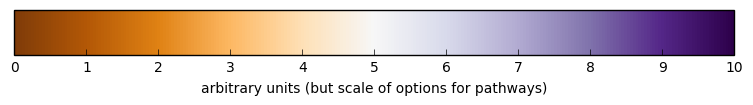

<module 'colorbar_only' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\colorbar_only.py'>

In [63]:
reload(colorbar_only)
#this will be the range of colors in the pathway maps (not green bc genes are green)

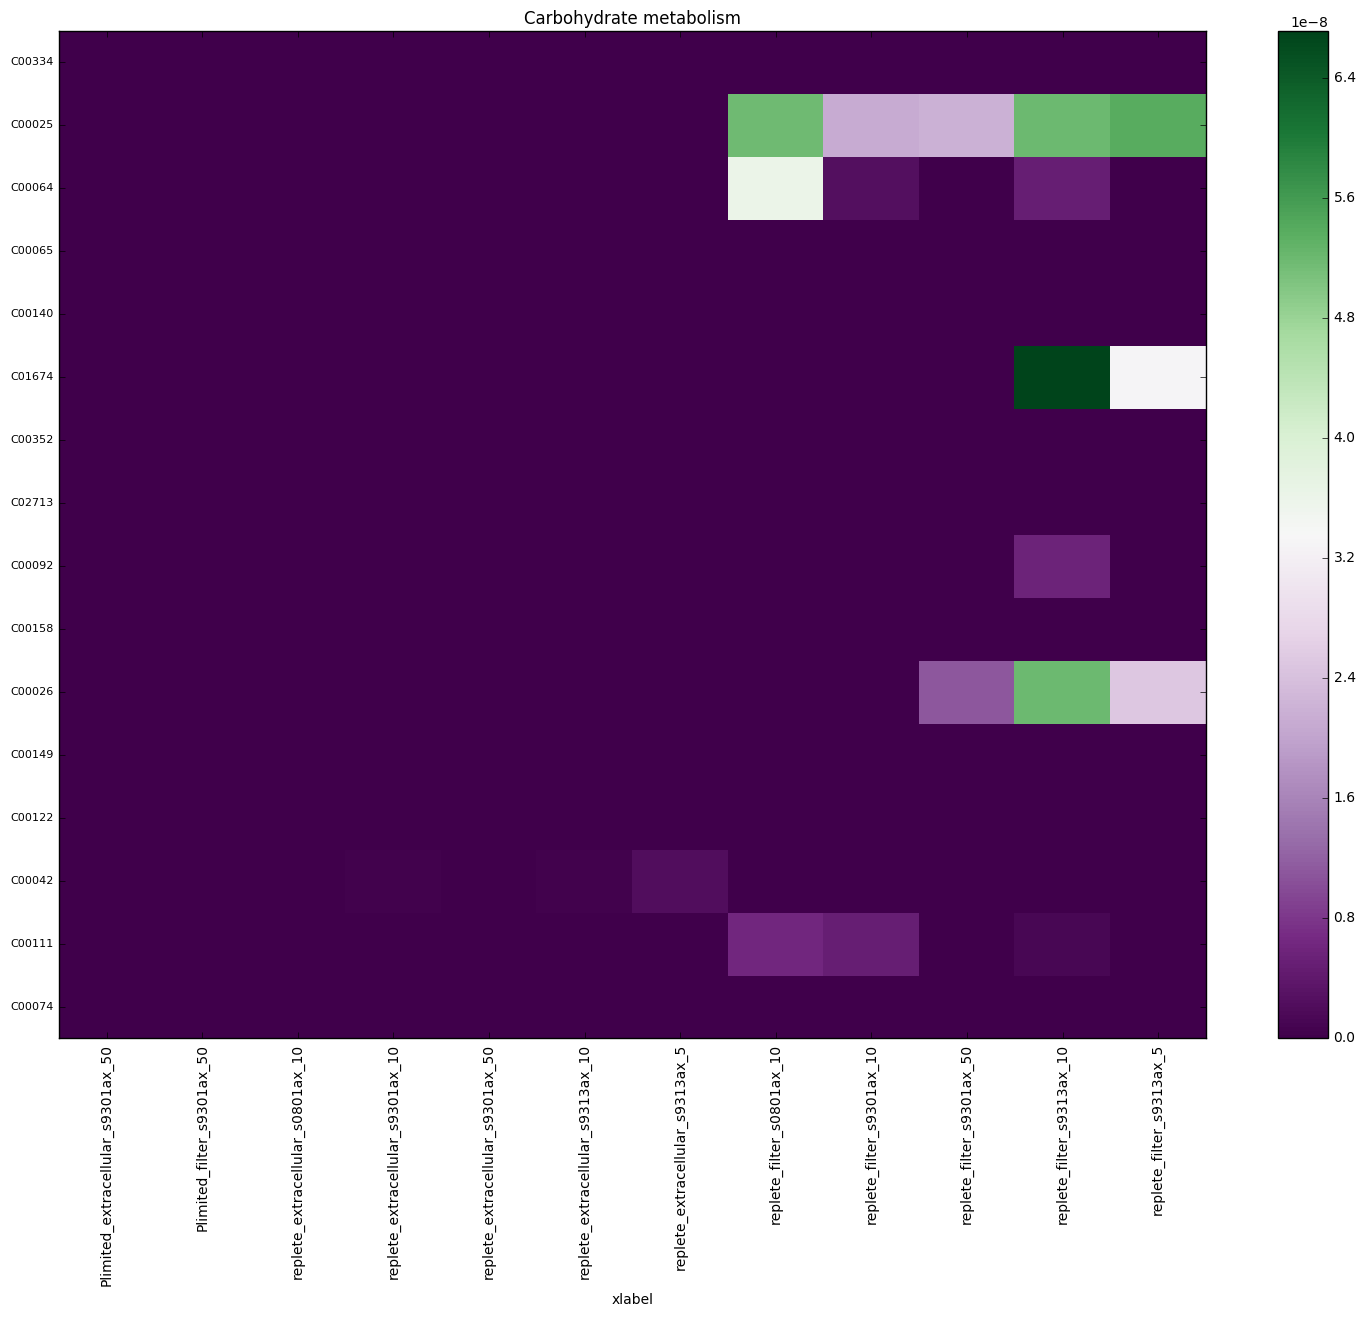

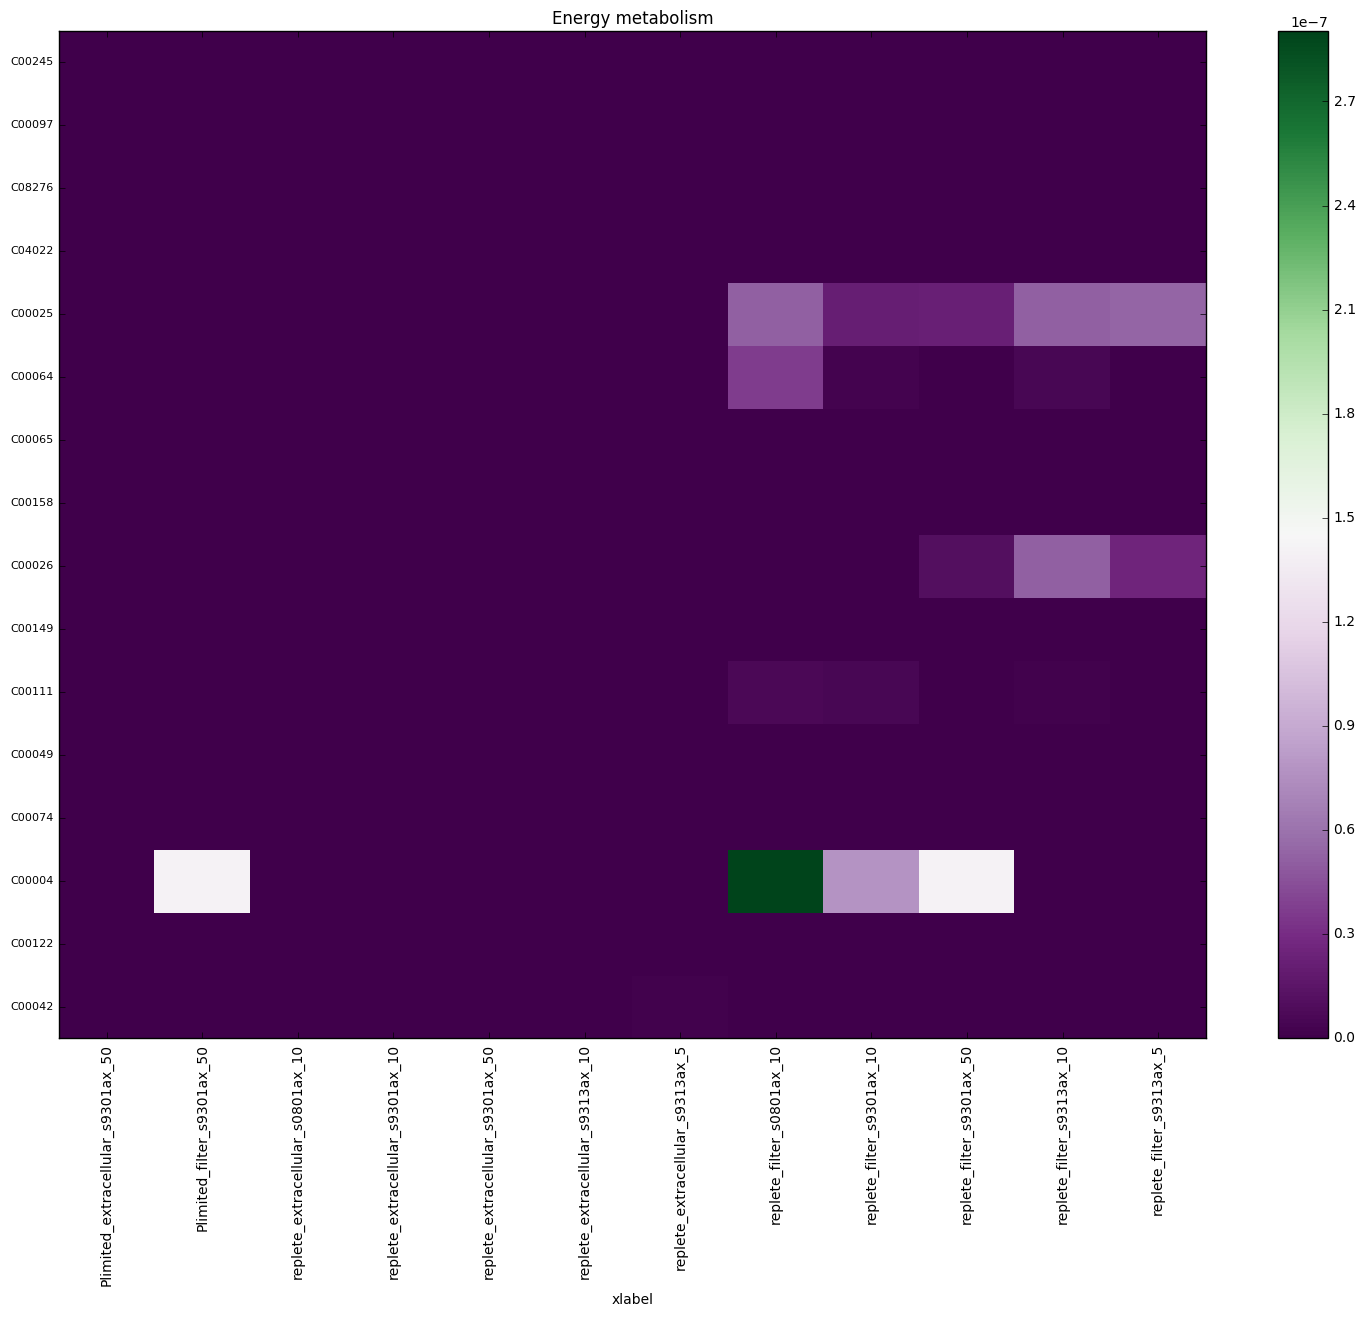

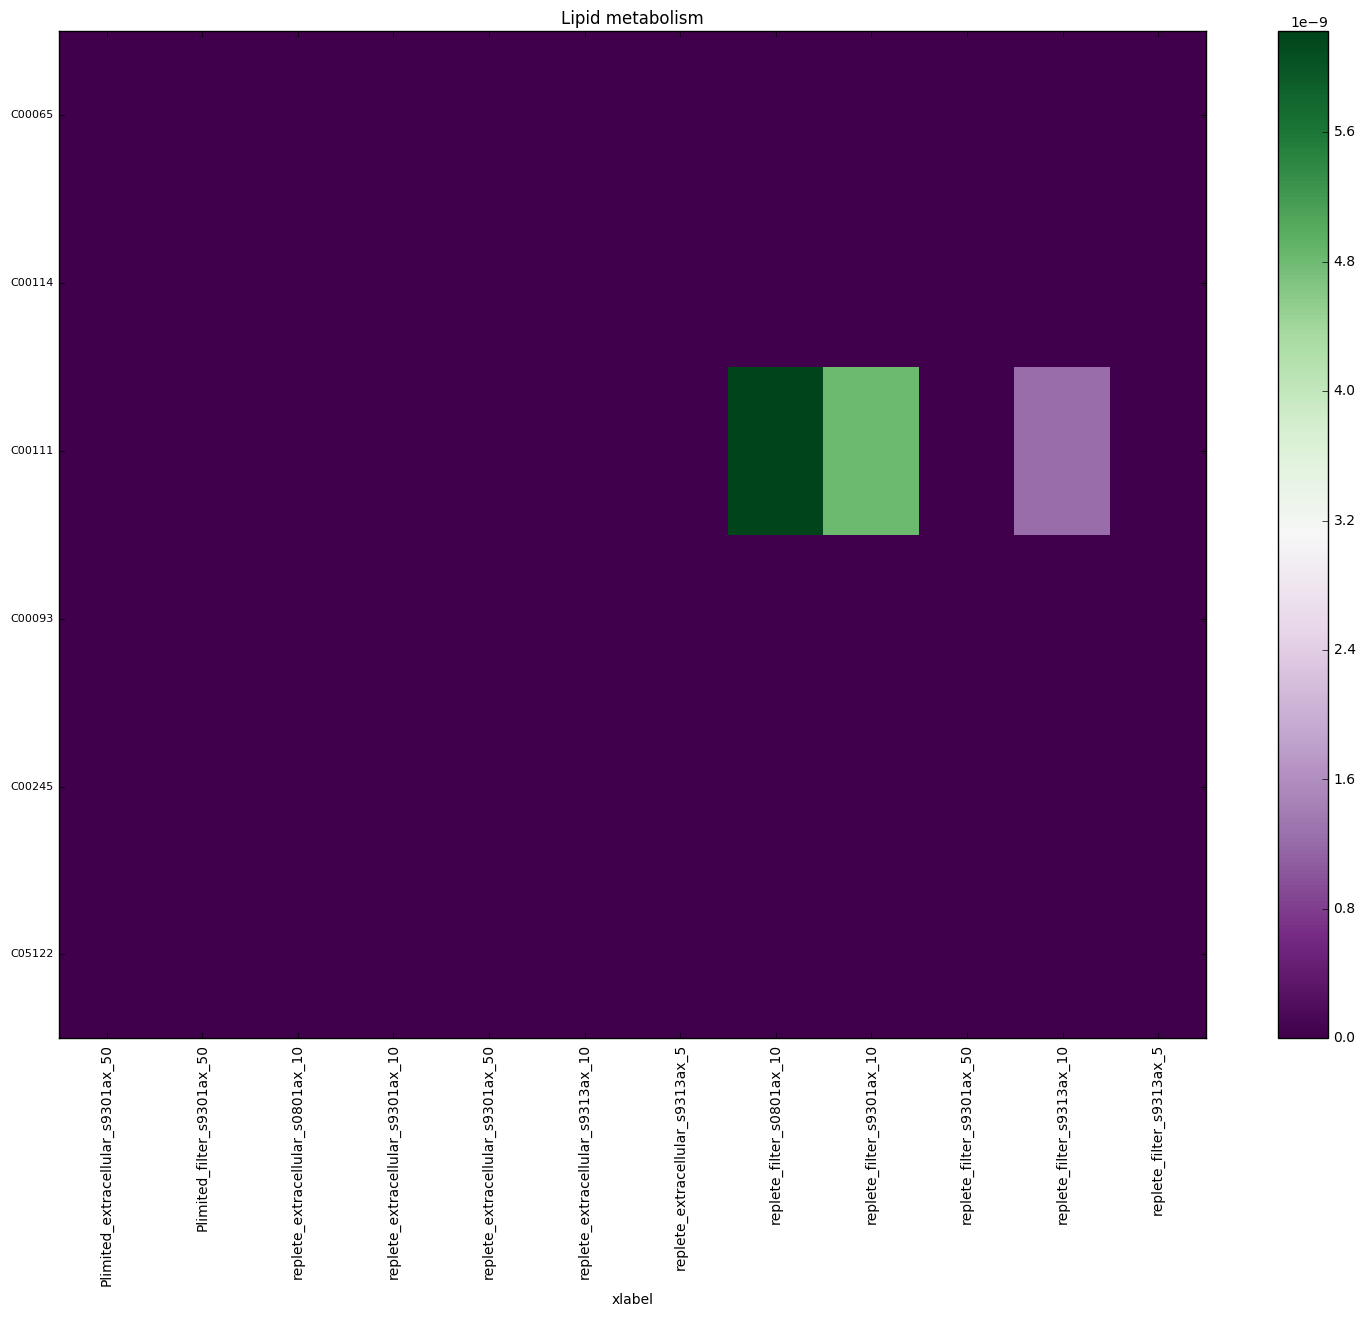

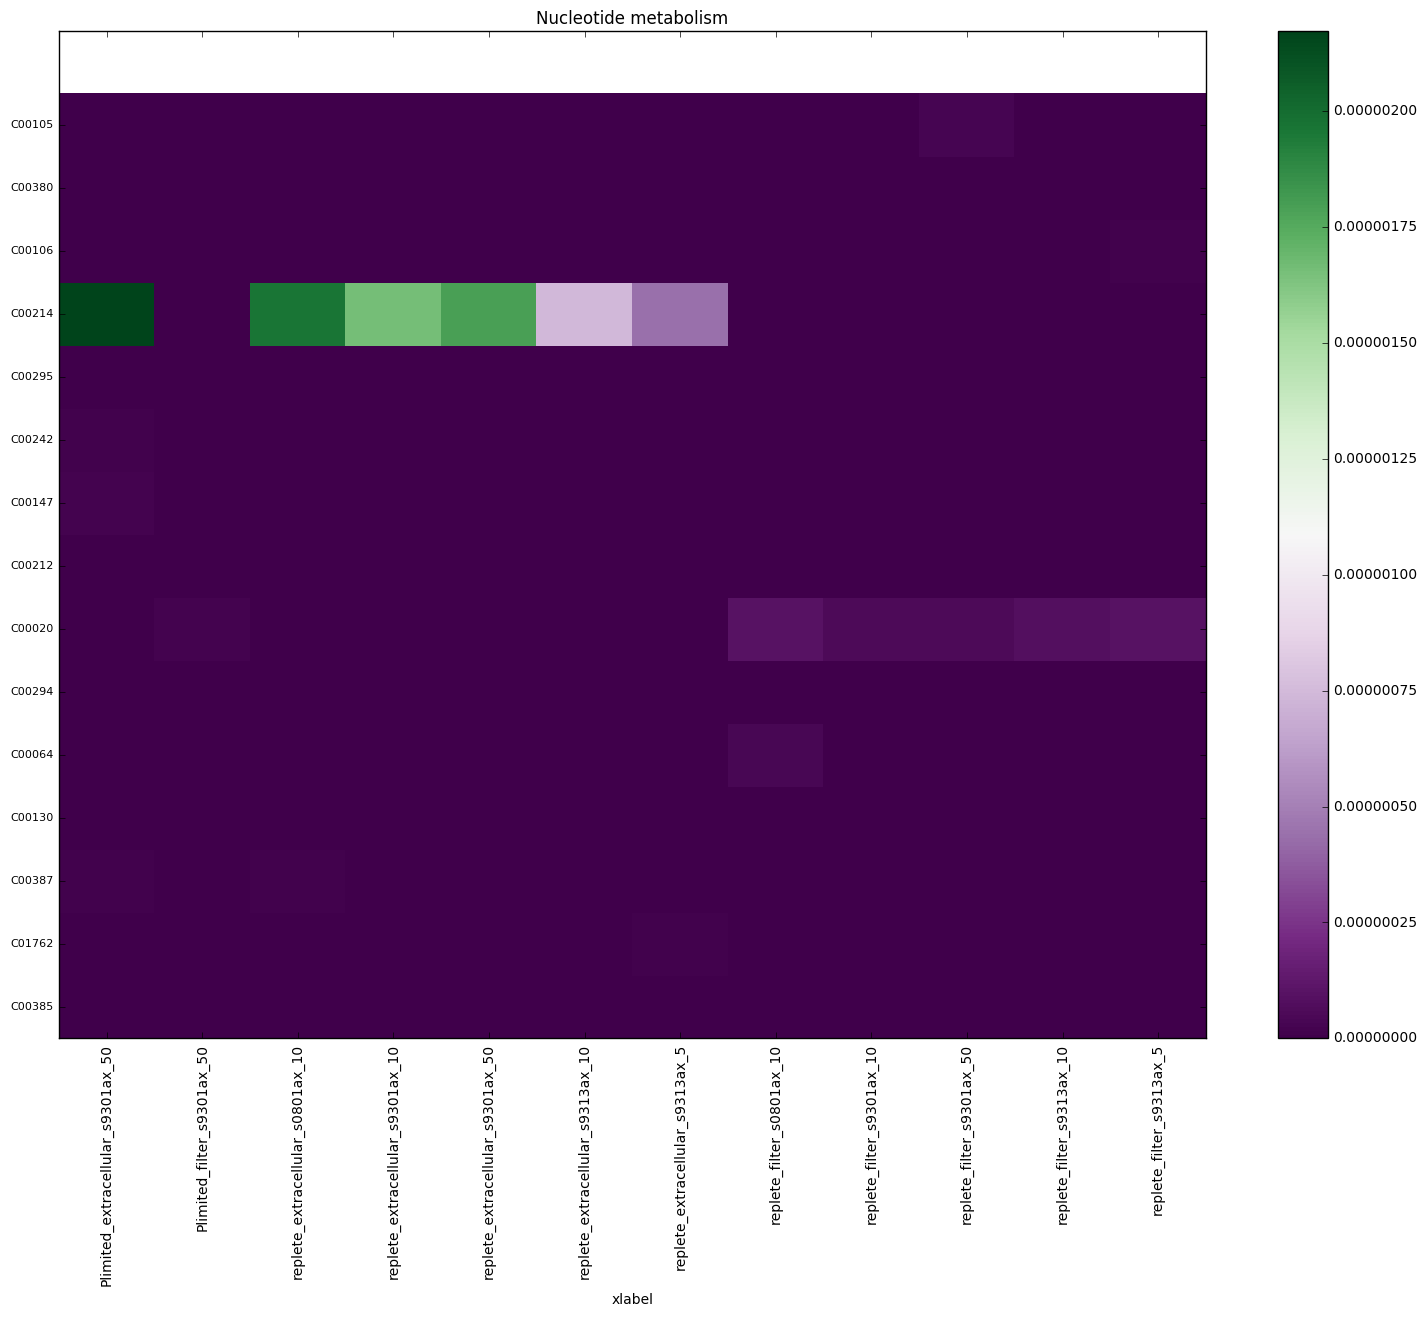

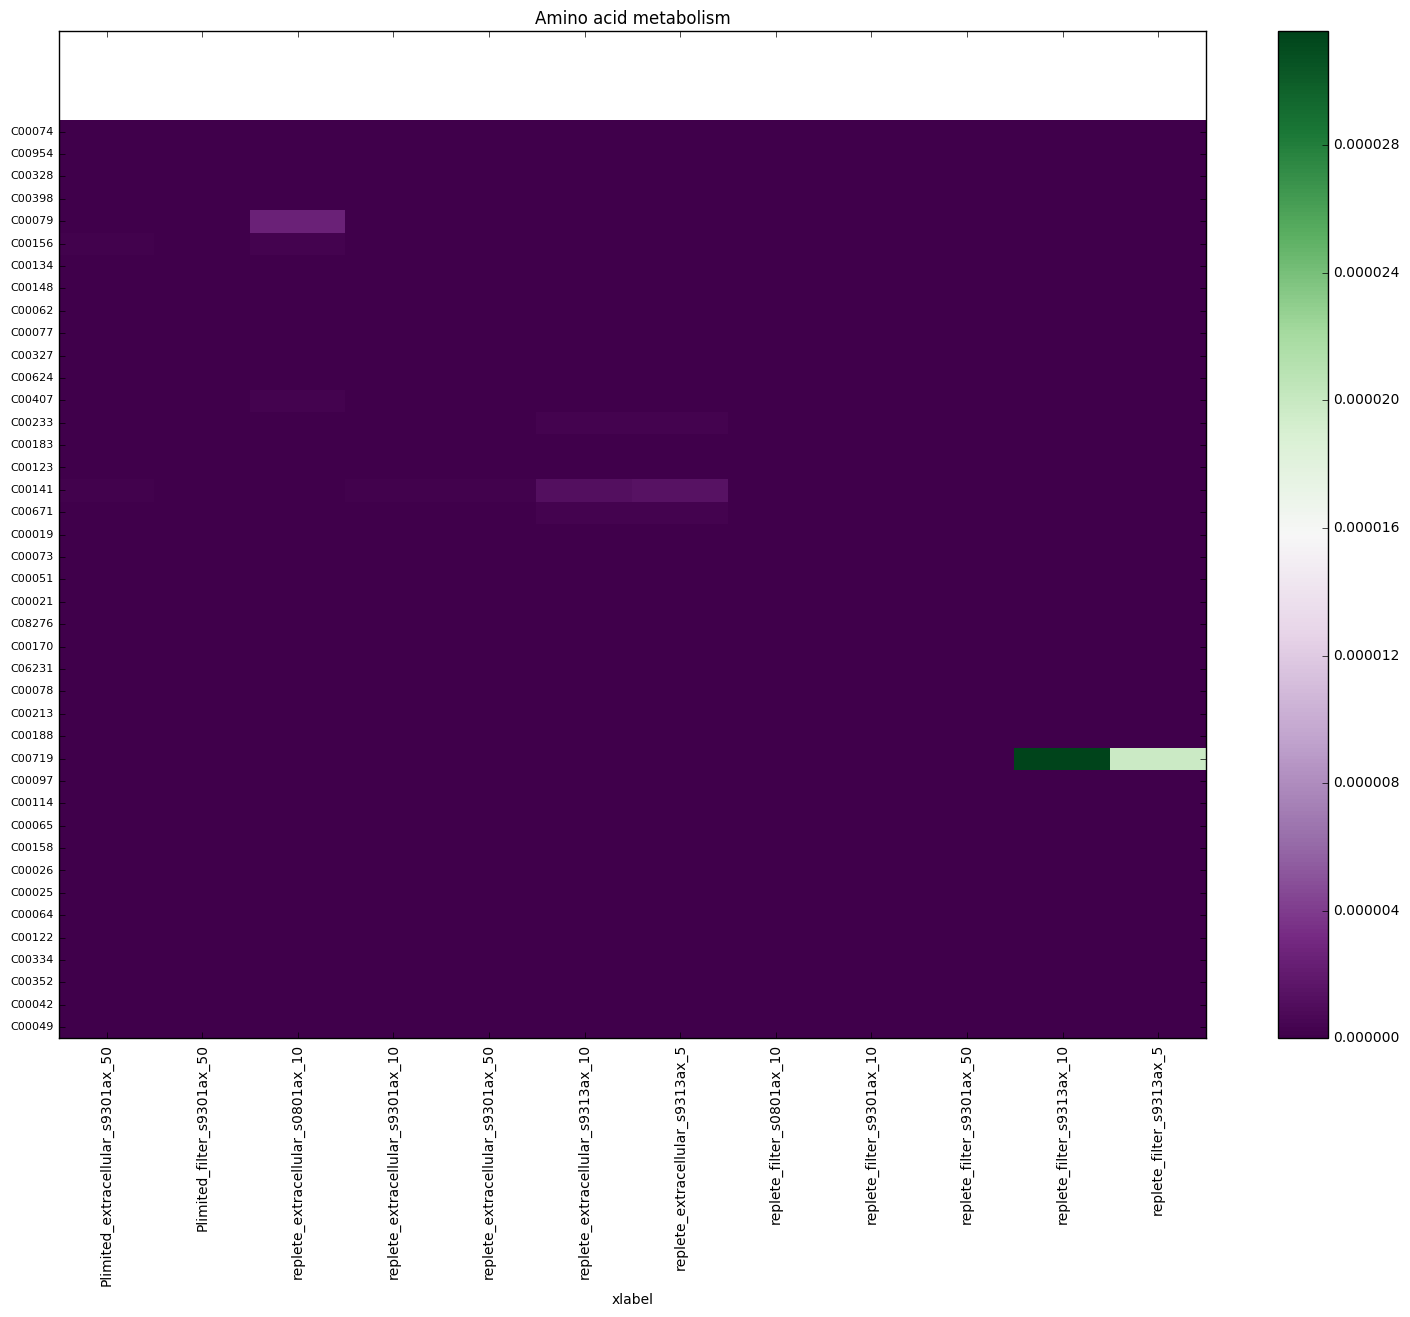

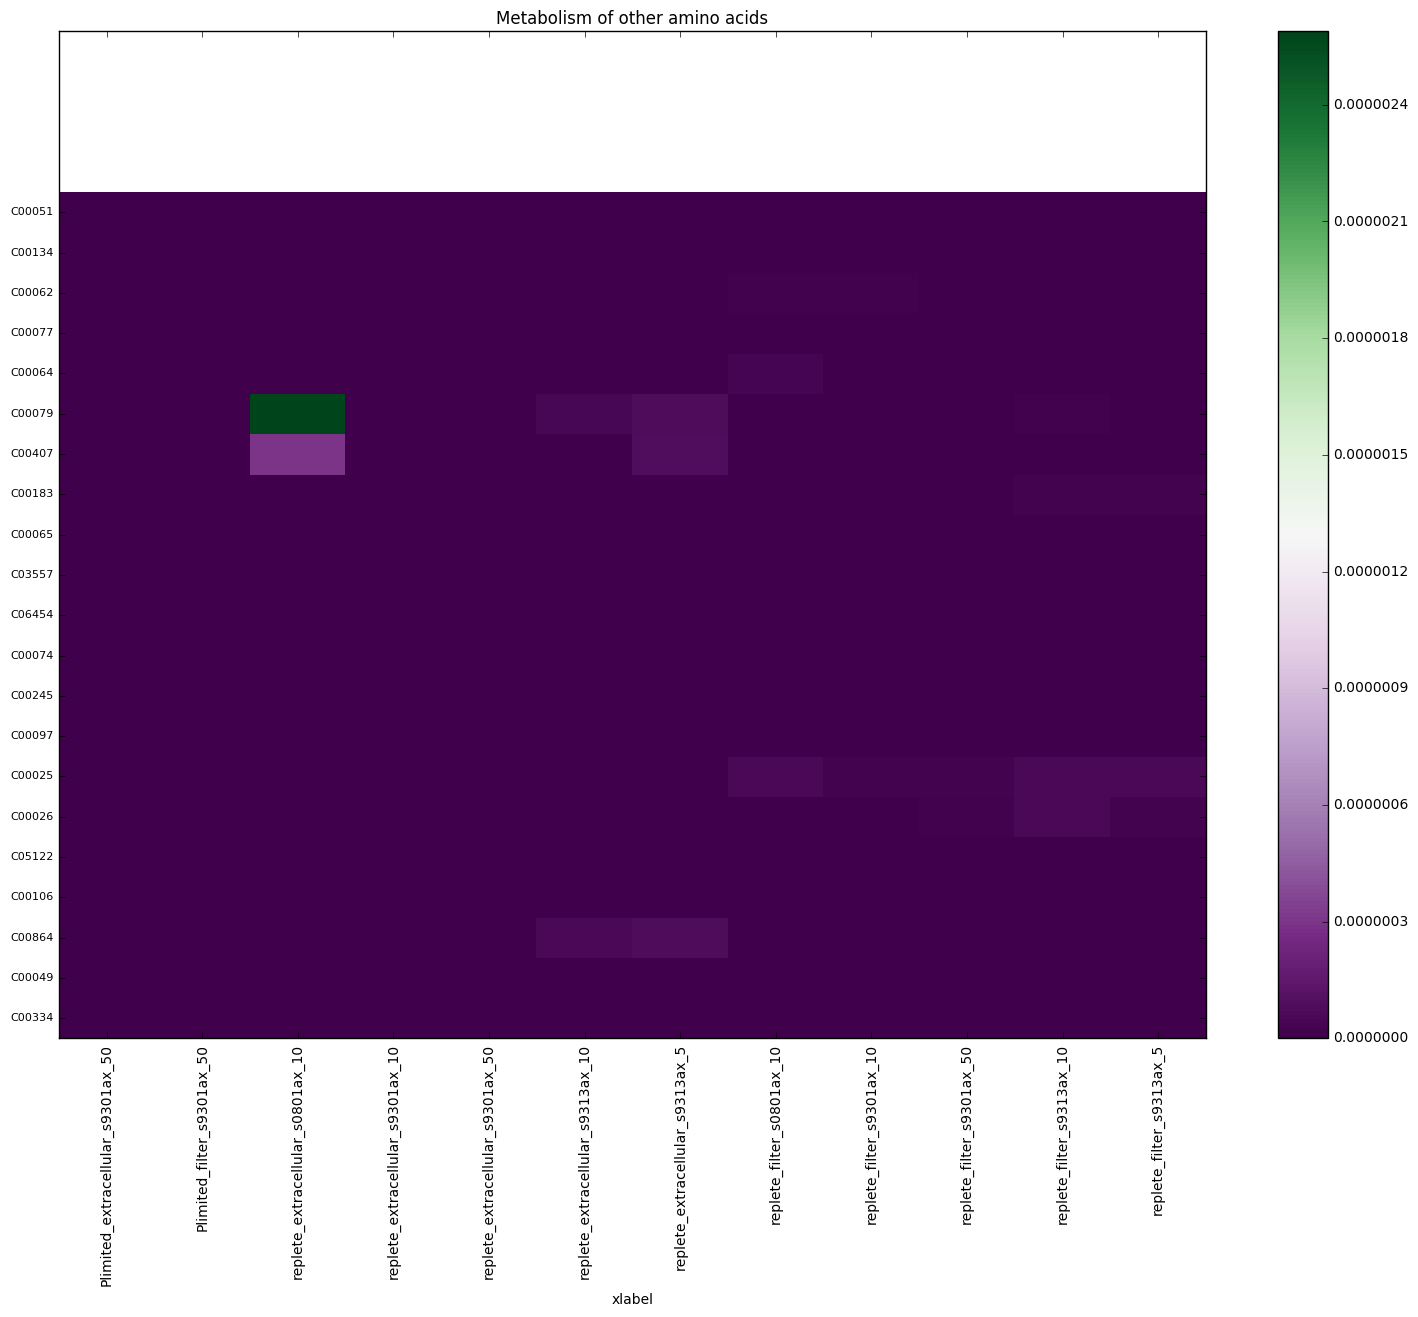

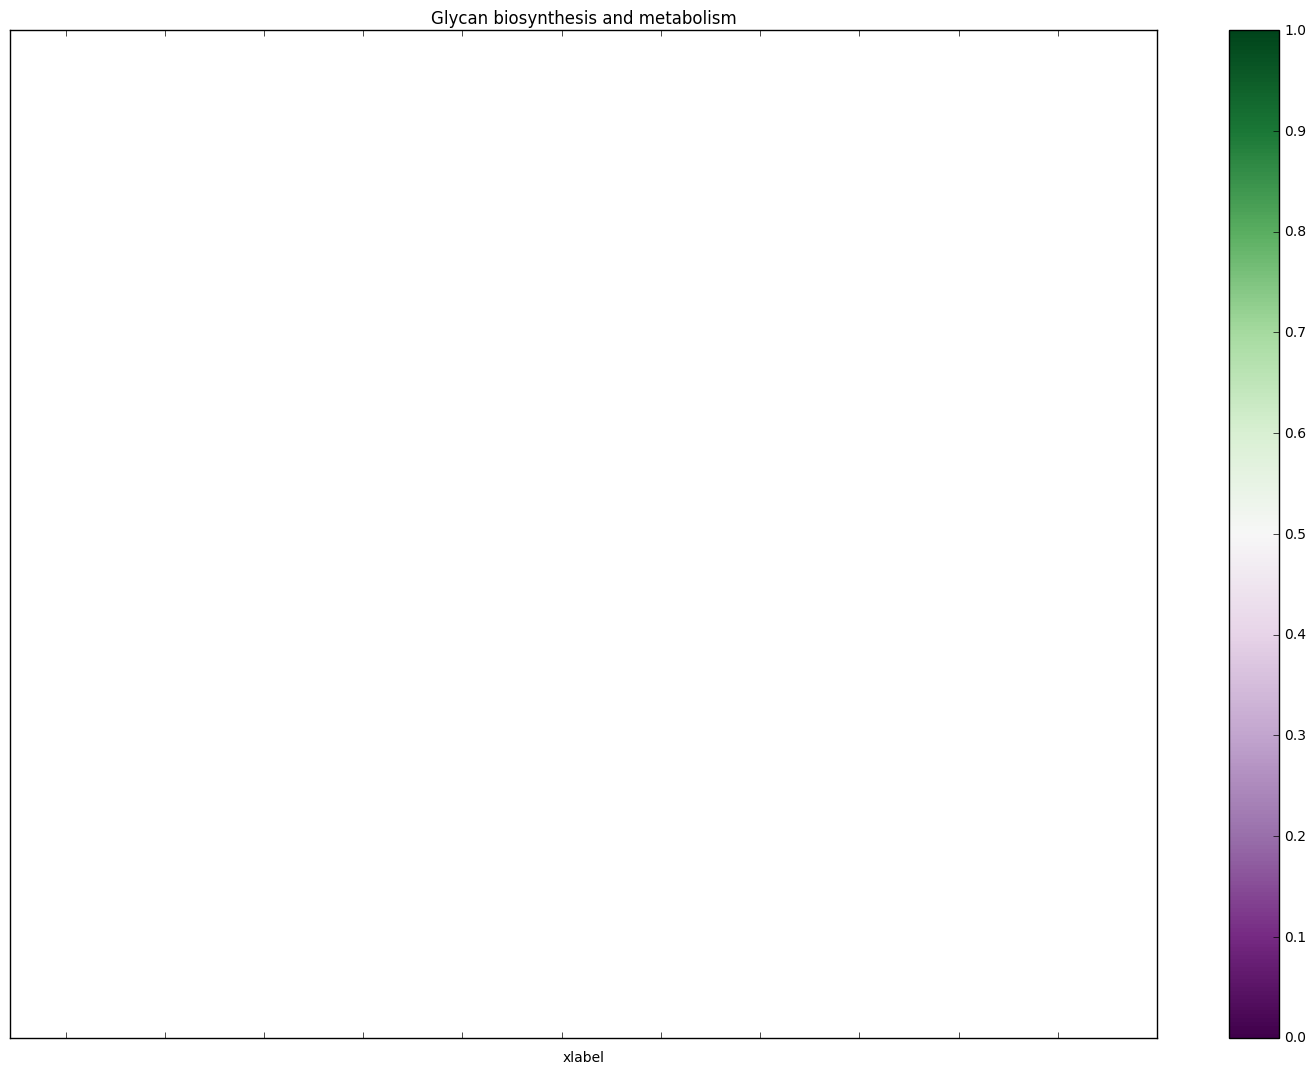

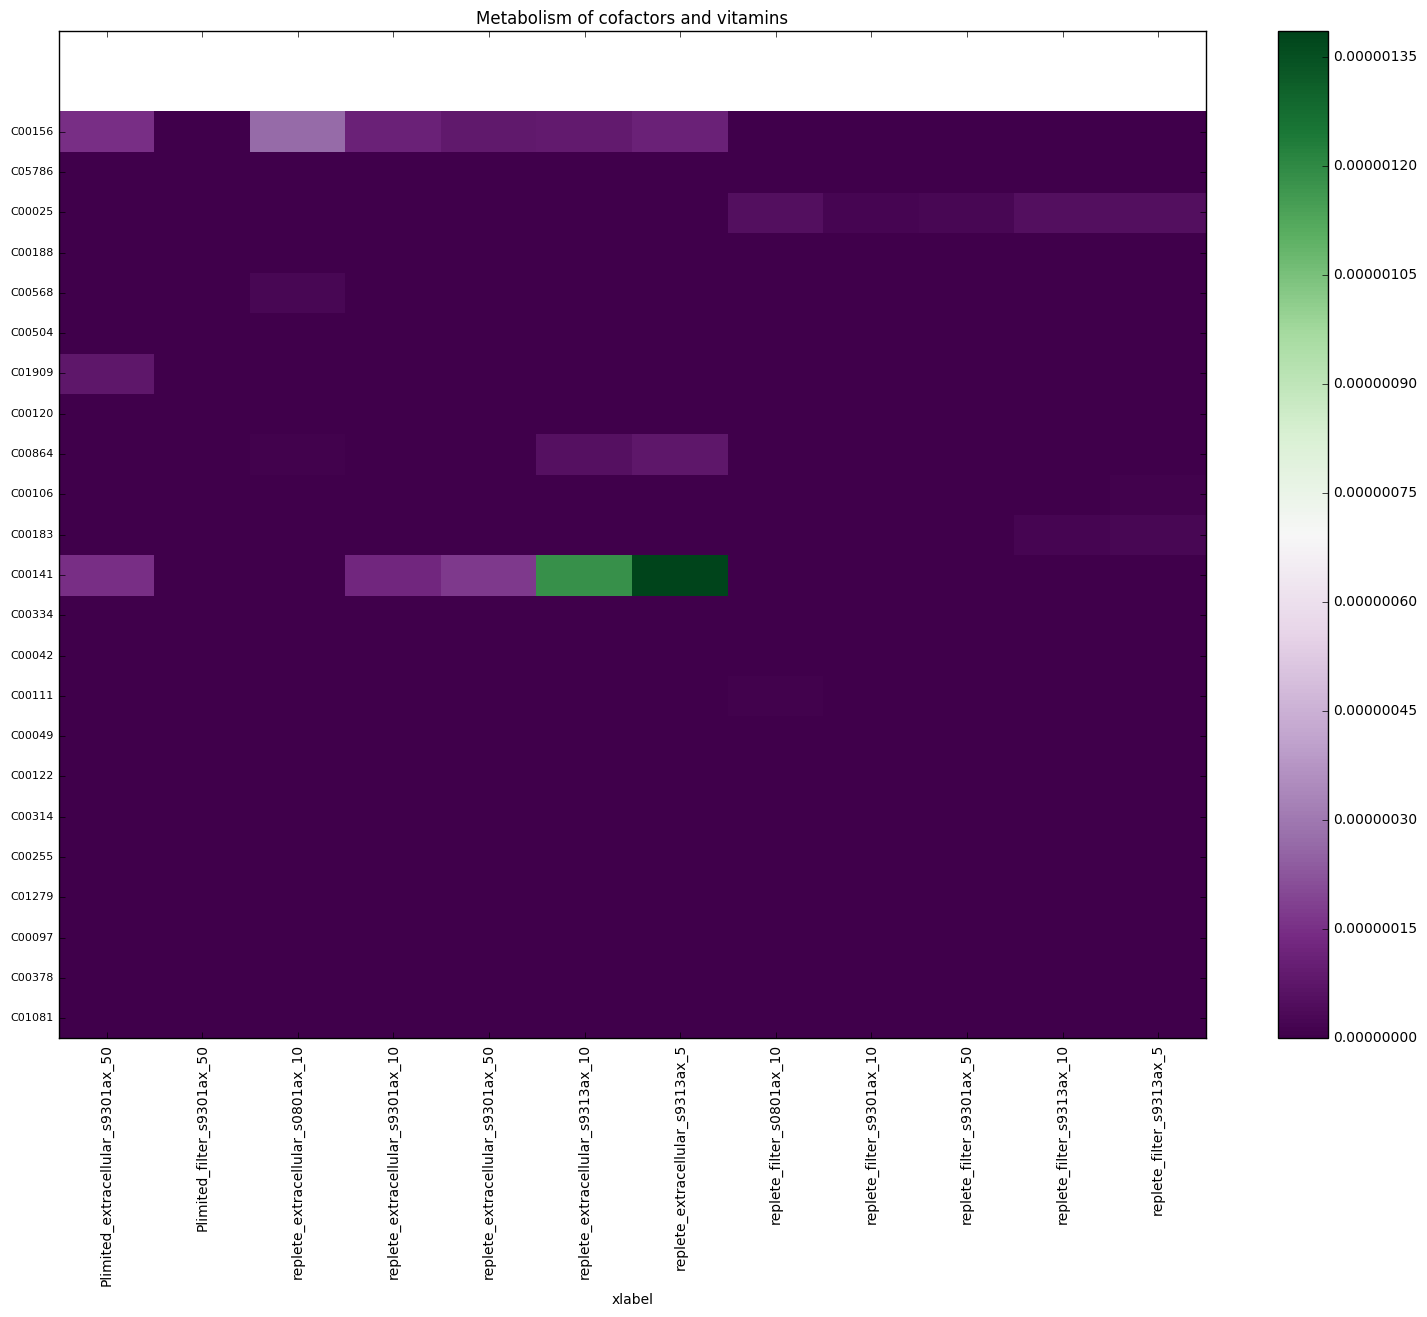

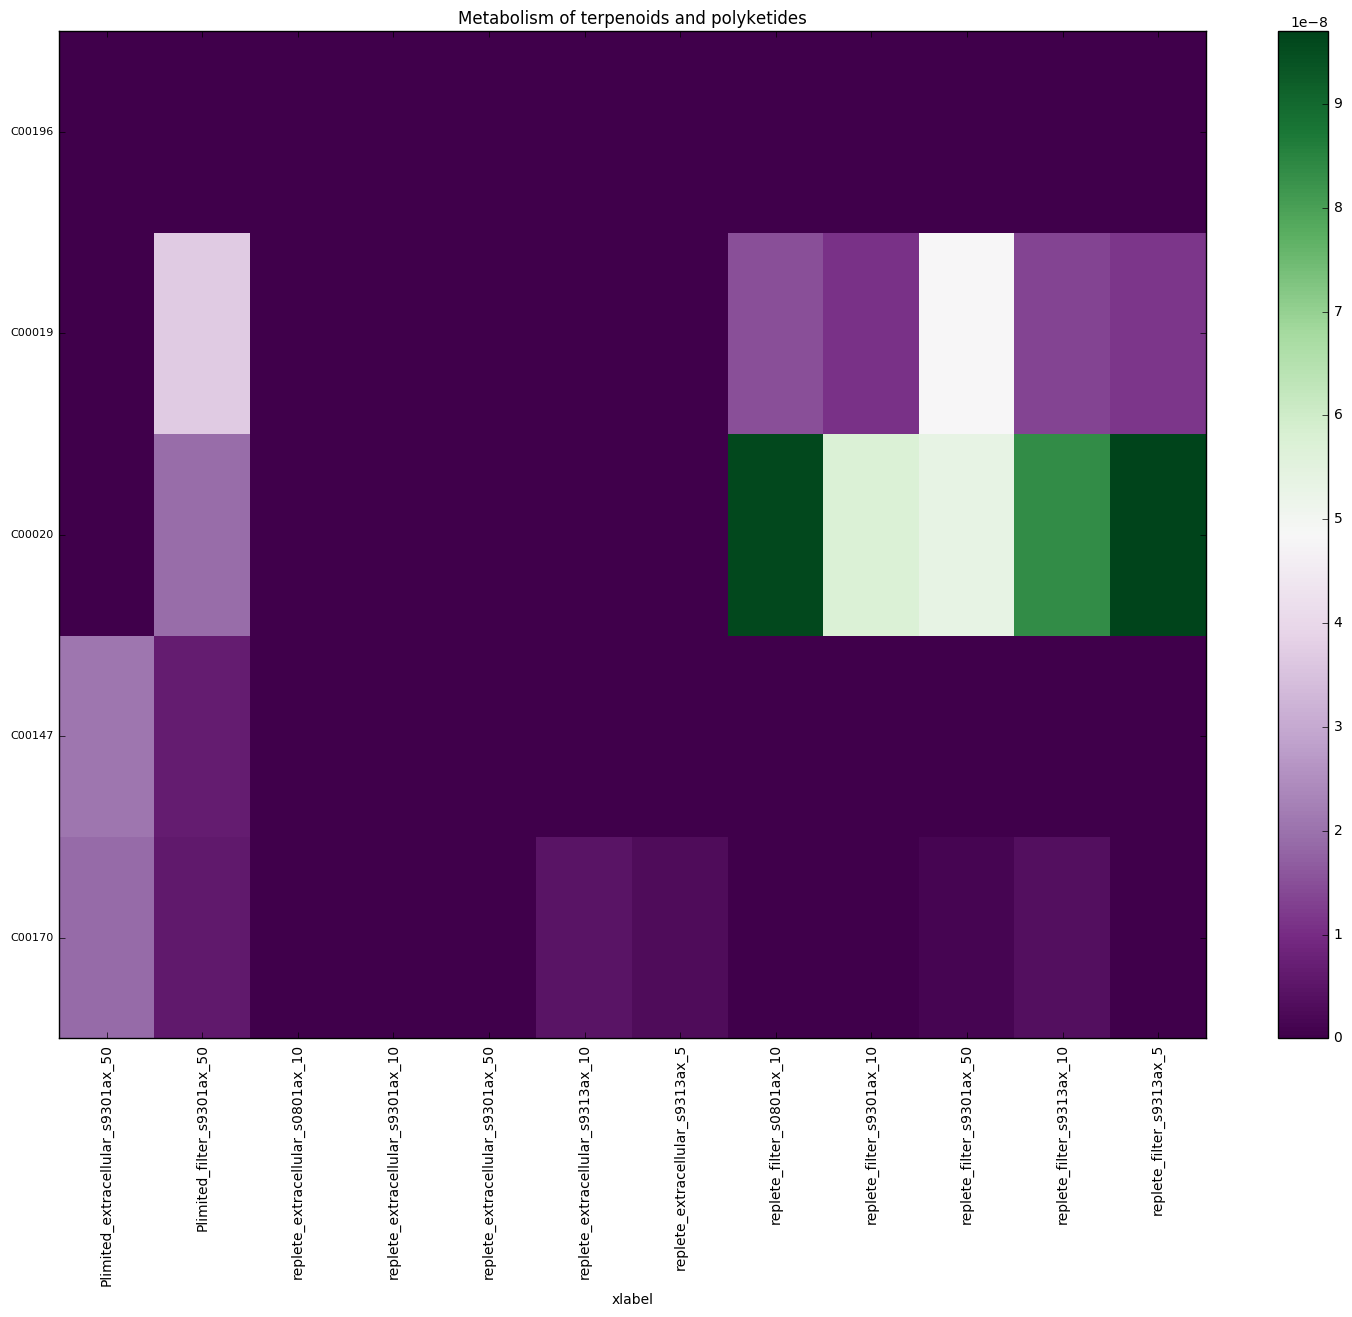

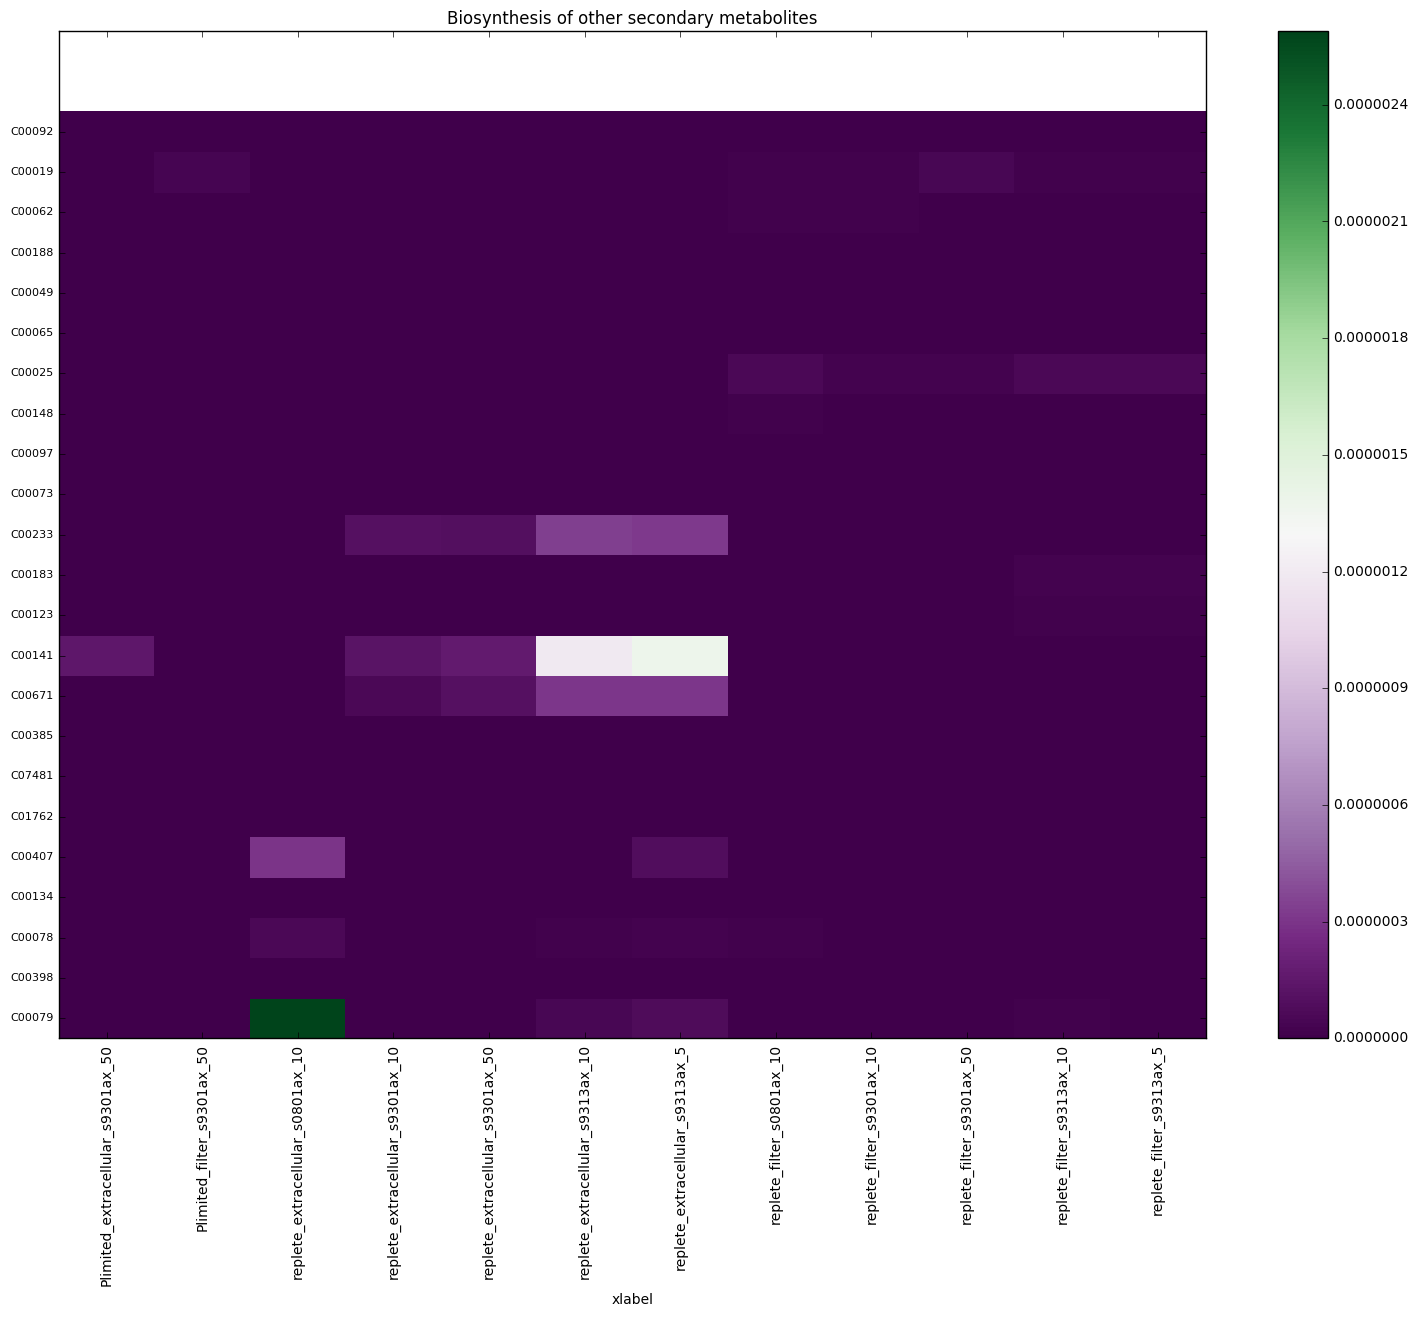

problem with this pathway 00983


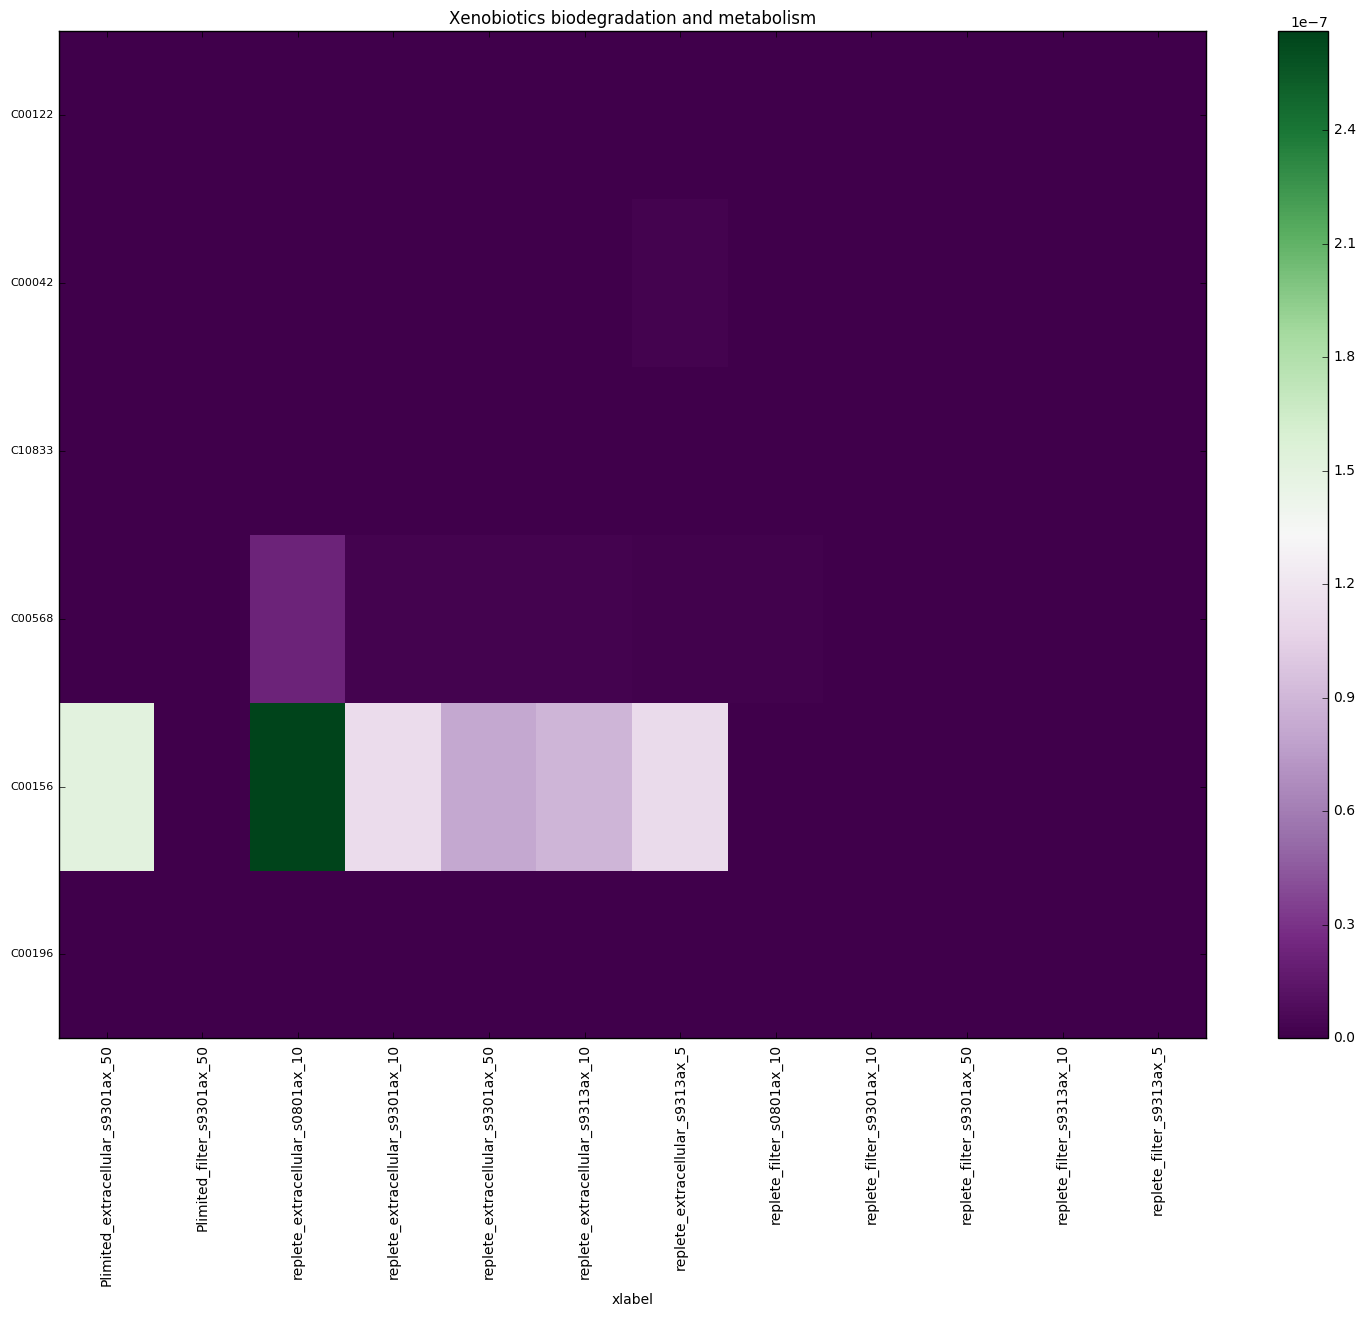

problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070
problem with this pathway 01070


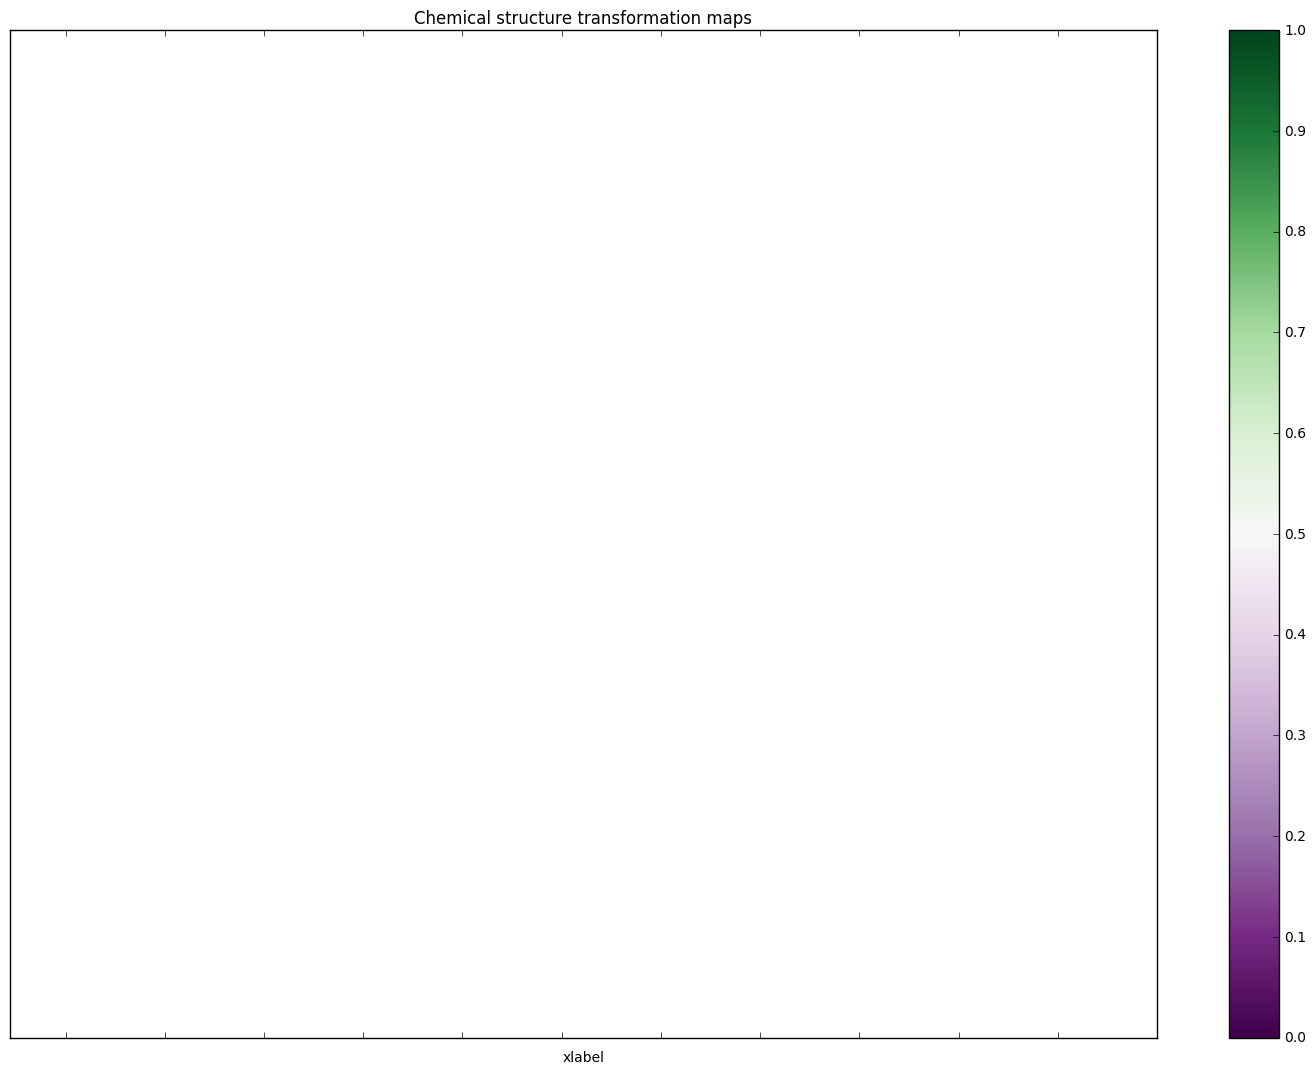

In [55]:
if True:
    ##this will take a while...
    for oneGroup in unMetabolismGroups:
        shortList = prunedBRITE.loc[(prunedBRITE['B']==oneGroup)] 
        onePath = shortList.loc[:,'map']
        onePath_ann = []
        for item in onePath:
            onePath_ann.append(oneStrain + item)

        #plot pathways divided by group, remember...can have pathways not annotated for this Pro strain
        for runOne in onePath_ann:    
            try:
                fxn_plotPathway.gatherDetails(runOne,oneGroup,useCO,CO_values)               
            except:
                print('problem with this pathway ' + item)

        #next line will make the color maps for each group: purple = low; green = high
        plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [ ]:
##fussing around with specific pathways and compounds

In [67]:
oneMap = 'ko00360'
oneCpd = 'C00156'

In [74]:
#kegg_get(oneMap).read()
genes = getKfrom_ko(oneMap)
compounds = getCfrom_ko(oneMap)

setG = set(genes)
setC = set(compounds)
setT = set(useCO)
intCompounds = setC.intersection(setT)

useColors = pal.colorbrewer.diverging.PuOr_4.hex_colors
#useColors = pal.colorbrewer.diverging.RdYlBu_11.hex_colors

#set the color of the mtab based on its value, only scale the values from this particular pathway
useCOsubset = CO_values.loc[intCompounds]
cmin = useCOsubset.min() #find min and max...ignore NaN and inf for the moment
cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

size = 20 #increase the size of the compounds in the plots

In [76]:
pathway = KGML_parser.read(kegg_get(oneMap, "kgml")) #no choice in gene color: green

In [79]:
useCOsubset


KEGG
C00122    0.000000
C00042    0.000000
C00156    0.000000
C00079    0.640927
dtype: float64

In [78]:
        dummy = useCOsubset.copy(deep = True)
        dummy.replace([np.inf],np.nan,inplace = True)
        for idx,item in enumerate(useCOsubset):
            if np.isnan(item):
                useCOsubset.iloc[idx] = 0
            elif np.isinf(item):
                useCOsubset.iloc[idx] = 10*cmax #make inf 10x the biggest value

        #now, find cmax again...use that downstream
        cmax = useCOsubset.replace([np.inf],np.nan).dropna(how = 'all').max()

        #use histogram to make the bins (complete hack)
        a,bin_edges = np.histogram(useCOsubset,bins = len(useColors)-3,range = (cmin,cmax))
        #now...put zero at beginning and inf at end
        #BUT - can actually have cases with values for all metabolites (novel concept)
        try:
            nz = useCOsubset.value_counts()[0] #count the number of zeros
            a = np.insert(a,0,nz)
            bin_edges = np.insert(bin_edges,0,0)
        except:
            pass
            
        try:
            nm = useCOsubset.value_counts()[cmax]
            a = np.append(a,nm)
            bin_edges = np.append(bin_edges,cmax)
        except:
            pass

        #then find the index for each number...this will be the index into useColors
        useIdx = np.digitize(useCOsubset,bin_edges)
        color_df = pd.DataFrame({'mtab': useCOsubset,'idx':useIdx})

ValueError: bins must be monotonically increasing or decreasing

In [77]:

# Change the colors of compounds
for element in pathway.compounds:
    for graphic in element.graphics:
        tc = element.name[4:10] #skip over the 'cpd:'
        if (tc in intCompounds):
            #in the pathway, set the color
            tempColor = useCOsubset.loc[tc]
            graphic.bgcolor = useColors[int(tempColor)] 
            graphic.width = size
            graphic.height = size

canvas = KGMLCanvas(oneMap, import_imagemap=True)
pdfName = 'mapWithColors_' + str(oneMap) + '.pdf'
canvas.draw('testingFolder' + '/' + pdfName)
pdfName = None #empty it in case that is where I am having issues       

ValueError: cannot convert float NaN to integer

In [19]:
#leave debris below here for now, notebook will stop at the 'raise' command in the next cell to keep me from running cells 
#of code that are not meant to be connected

In [ ]:
raise

In [64]:
#import plotByGroup
reload(plotByGroup)

<module 'plotByGroup' from 'C:\\Users\\krista\\Documents\\GitHub\\Pro_mtabs\\plotByGroup.py'>

In [65]:
#for oneGroup in unMetabolismGroups:
oneGroup = 'Carbohydrate metabolism'

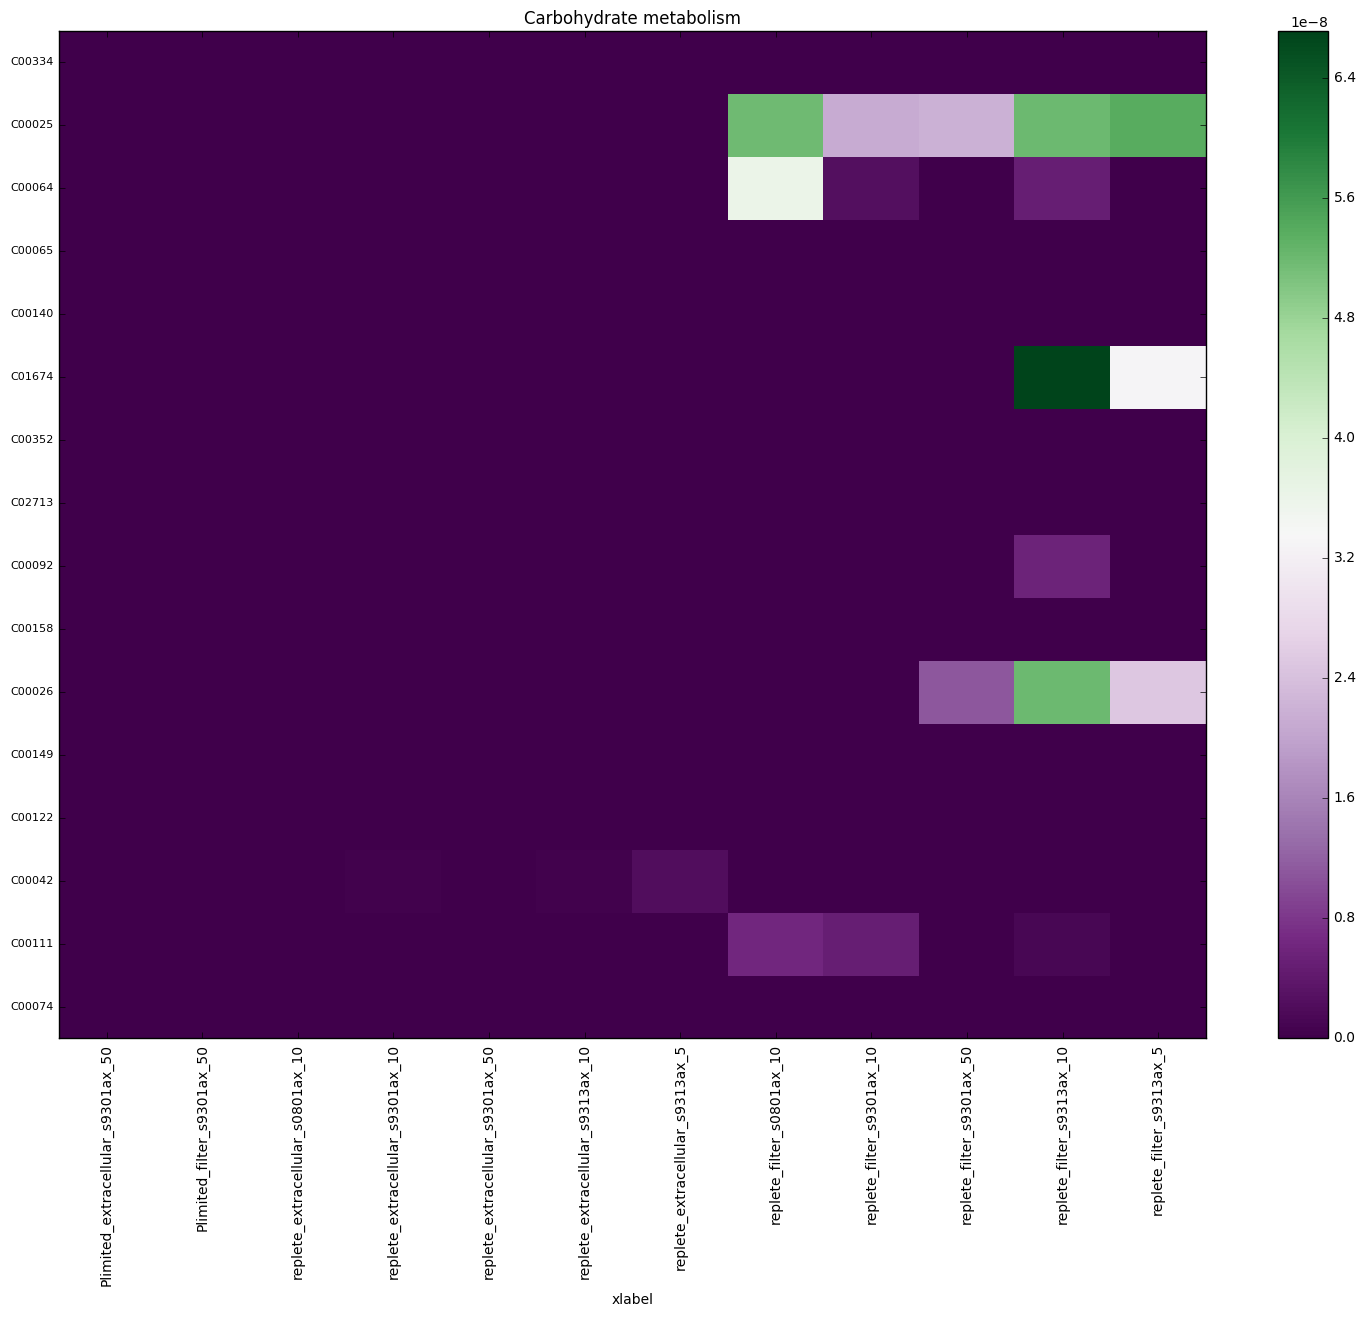

In [66]:
plotByGroup.plotGroup(oneGroup,prunedBRITE,useCO,mtabPruned,oneStrain)

In [28]:
gatherGroup

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s9313ax_10,replete_extracellular_s9313ax_5,replete_filter_s0801ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s9313ax_10,replete_filter_s9313ax_5
C00074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
type(gatherGroup)

pandas.core.frame.DataFrame

In [39]:
'C00074' in gatherGroup.index

True

In [42]:
if ('C00074' in gatherGroup.index):
    print('yes')

yes


In [36]:
gatherGroup

,Plimited_extracellular_s9301ax_50,Plimited_filter_s9301ax_50,replete_extracellular_s0801ax_10,replete_extracellular_s9301ax_10,replete_extracellular_s9301ax_50,replete_extracellular_s9313ax_10,replete_extracellular_s9313ax_5,replete_filter_s0801ax_10,replete_filter_s9301ax_10,replete_filter_s9301ax_50,replete_filter_s9313ax_10,replete_filter_s9313ax_5
C00074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
